<font size="+3"><strong>Autoregressive Models</strong></font>

In [1]:
# ------------------------------------------------------------
# 📊 Import Required Libraries
# ------------------------------------------------------------

# Suppress specific warning messages for cleaner output
import warnings

# Data visualization (static plots)
import matplotlib.pyplot as plt

# Data manipulation and analysis
import pandas as pd

# Interactive data visualization
import plotly.express as px

# Evaluate model performance using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

# Plot autocorrelation and partial autocorrelation for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Build autoregressive (AR) models for time series forecasting
from statsmodels.tsa.ar_model import AutoReg

# Ignore future warnings to keep notebook output clean
warnings.simplefilter(action="ignore", category=FutureWarning)


# Prepare Data

## Import data

In [2]:
def wrangle(filepath):

    # Load CSV file and set 'timestamp' as the index
    df = pd.read_csv(filepath).set_index("timestamp")

    # Convert index to datetime format
    df.index = pd.to_datetime(df.index, errors="coerce", format="mixed")

    # Localize timestamps to UTC and convert to Africa/Nairobi timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outlier P2 readings above 500
    df = df[df["P2"] < 500]

    # Resample data hourly, compute mean, and forward-fill missing values
    df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

    # Return cleaned DataFrame
    return df


In [3]:
y = wrangle("../nairobi-city-air-quality.csv")
y.head()

,P2
timestamp,
2018-09-01 03:00:00+03:00,17.541667
2018-09-01 04:00:00+03:00,15.800000
2018-09-01 05:00:00+03:00,11.420000
2018-09-01 06:00:00+03:00,11.614167
2018-09-01 07:00:00+03:00,17.665000


In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2018-09-01 03:00:00+03:00 to 2019-01-01 02:00:00+03:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P2      2928 non-null   float64
dtypes: float64(1)
memory usage: 45.8 KB


## Explore

### 🔁 Autocorrelation and Partial Autocorrelation Analysis

In this step, we explore the temporal dependencies in the PM 2.5 readings using **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots.

**Steps to perform:**

1. **Create an ACF Plot**
   - Use `plot_acf(y)` to visualize how each value in the time series correlates with its **past values (lags)**.
   - Label the axes clearly:
     - **x-axis:** "Lag [hours]"
     - **y-axis:** "Correlation Coefficient"

2. **Create a PACF Plot**
   - Use `plot_pacf(y)` to display the **direct correlation** between a data point and its lagged values, after controlling for the effects of shorter lags.
   - Label the axes the same way:
     - **x-axis:** "Lag [hours]"
     - **y-axis:** "Correlation Coefficient"

These plots help identify significant lag relationships in the time series — essential for selecting the appropriate number of lags in autoregressive (AR) models.


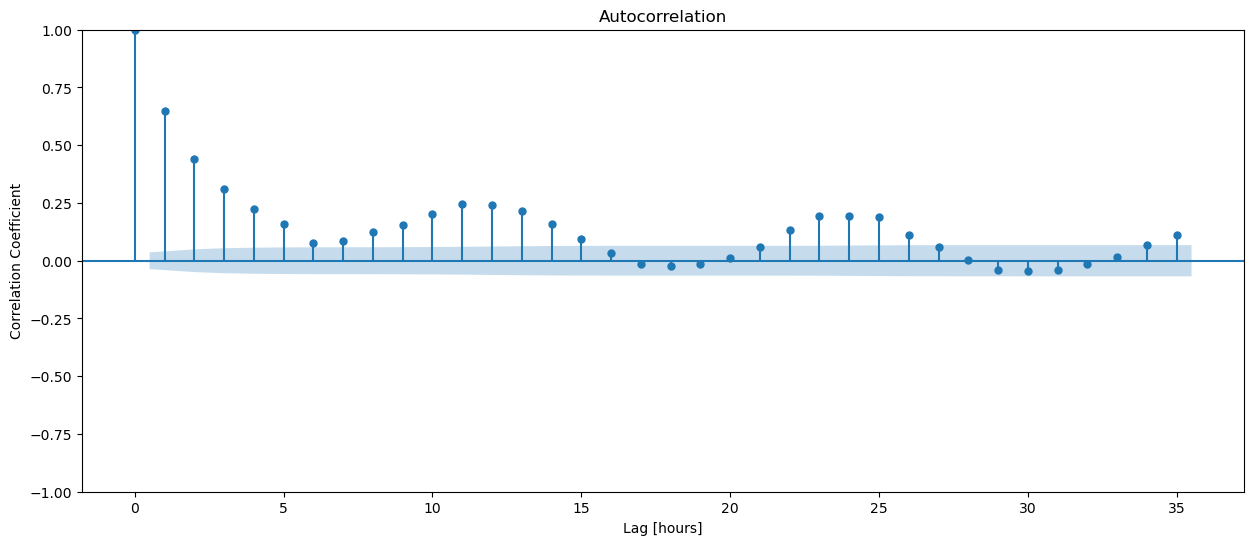

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

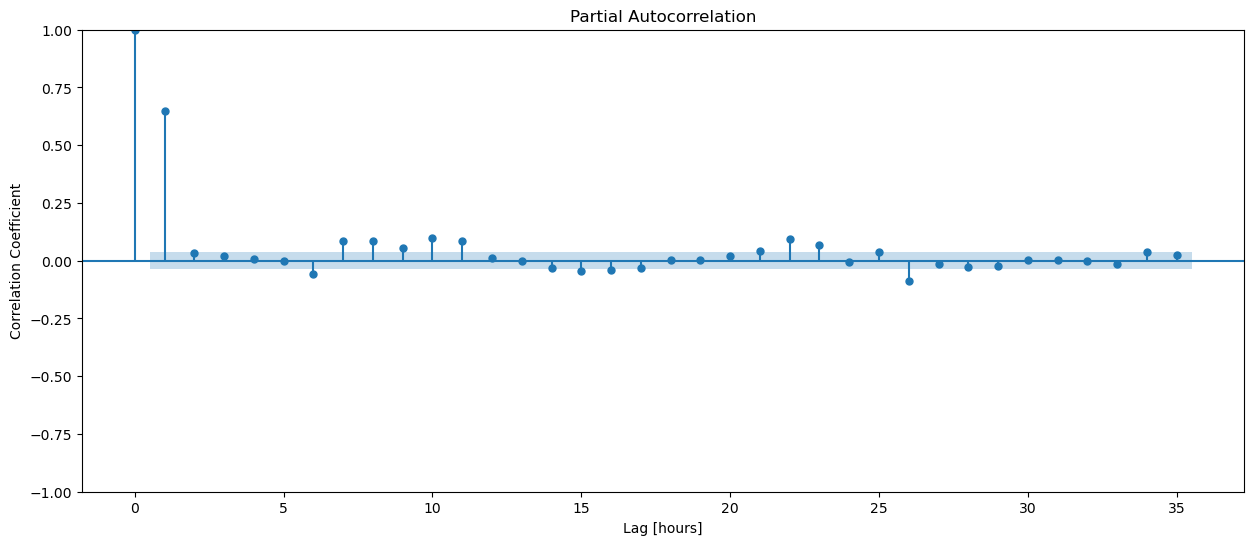

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Split

### ✂️ Splitting the Target Variable into Training and Test Sets

To evaluate the performance of our time series model, we divide the target variable (`y`) into **training** and **test** subsets.

**Steps to perform:**

1. **Chronological Split**
   - Use the **first 95%** of the data for the **training set** (`y_train`).
   - Use the **remaining 5%** for the **test set** (`y_test`).
   - Since this is time series data, we **do not shuffle** — preserving the time order is critical.

2. **Purpose**
   - The training set is used to **fit** the model.
   - The test set is used to **evaluate** how well the model generalizes to unseen, future data.

This ensures that the model is tested on data that chronologically follows the training period, simulating real-world forecasting conditions.


In [7]:
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]

y_test = y.iloc[cutoff_test:]

# Build Model

## Baseline

### 📉 Calculate the Baseline Mean Absolute Error (MAE)

Before building a predictive model, we establish a **baseline** to measure our model’s improvement.

**Steps to perform:**

1. **Baseline Definition**  
   - Use a simple **naïve forecasting approach**, where each predicted value equals the **previous observation**.  
   - This represents a “do nothing” model that assumes no change from one time step to the next.

2. **Calculate the Baseline MAE**  
   - Compute the **Mean Absolute Error (MAE)** between the actual and predicted values.  
   - The MAE quantifies the average magnitude of prediction errors, regardless of direction.

3. **Purpose**  
   - The baseline MAE serves as a **benchmark** — your model should aim to achieve a **lower MAE** than this baseline to be considered effective.



In [8]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: P2    9.22
dtype: float64
Baseline MAE: 3.71


## Iterate

### 🤖 Train an AutoReg Model and Evaluate Training Performance

Next, we build an **AutoRegressive (AR) model** to capture temporal dependencies in our time series.

**Steps to perform:**

1. **Model Initialization**  
   - Instantiate an `AutoReg` model from `statsmodels.tsa.ar_model`.  
   - Set the `lags` argument to **26**, meaning the model will use the previous 26 hourly observations to predict the next value.

2. **Model Fitting**  
   - Fit the model on the **training data (`y_train`)** to learn the relationship between past and current readings.

3. **Training Predictions**  
   - Generate predictions for the training period using the fitted model.  
   - Compare these predicted values with the actual training data.

4. **Calculate Training MAE**  
   - Compute the **Mean Absolute Error (MAE)** between the true and predicted values.  
   - This evaluates how accurately the model captures trends in the training set.

The training MAE helps us understand the model’s initial fit before testing on unseen data.


In [9]:
model = AutoReg(y_train,lags=26).fit()

In [10]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.281303238144459


### 📊 Analyze Model Residuals

After fitting the model, it’s essential to evaluate how well it captures the patterns in the training data by analyzing the **residuals**.

**Steps to perform:**

1. **Calculate Residuals**  
   - Compute residuals as the **difference** between the actual (`y_train`) and predicted (`y_pred`) values.  
   - Mathematically:  
     \[
     \text{residuals} = y_{\text{train}} - y_{\text{pred}}
     \]

2. **Visualize Residuals**  
   - Create a **time series plot** of the residuals to check for patterns or autocorrelation.  
   - Ideally, residuals should appear as **white noise** — randomly scattered around zero with no visible trend.

3. **Purpose**  
   - Residual analysis helps determine whether the model has captured all meaningful structure in the data.  
   - If patterns remain, it suggests the model could be improved.


In [11]:
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2018-12-25 19:00:00+03:00   -0.391842
2018-12-25 20:00:00+03:00   -1.573292
2018-12-25 21:00:00+03:00   -0.736029
2018-12-25 22:00:00+03:00   -2.022408
2018-12-25 23:00:00+03:00   -0.062279
Freq: h, dtype: float64

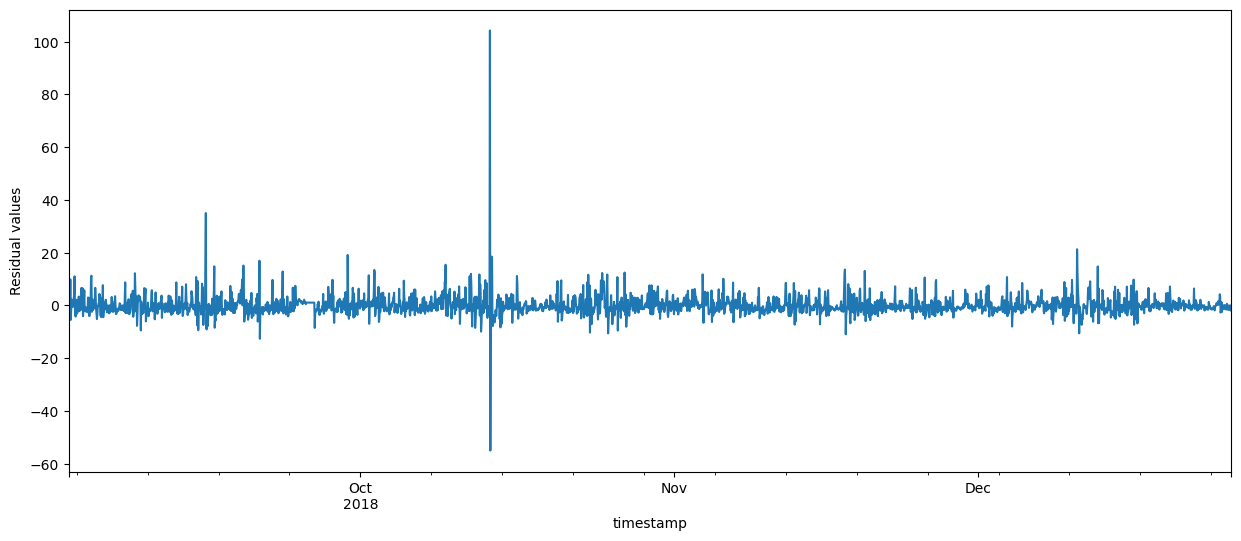

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual values",ax=ax);

### 📈 Visualize Residual Distribution and Autocorrelation

To further evaluate model performance, we examine the **distribution** and **autocorrelation** of the residuals.

**Steps to perform:**

1. **Histogram of Residuals**  
   - Plot a **histogram** of `y_train_resid` to visualize the distribution of errors.  
   - Ideally, residuals should be **normally distributed** and centered around zero.  
   - Significant skewness or outliers may indicate model bias or unaccounted patterns.

2. **ACF Plot of Residuals**  
   - Generate an **Autocorrelation Function (ACF)** plot for `y_train_resid`.  
   - This helps identify whether residuals are **independent over time**.  
   - If significant autocorrelations remain, the model might not have captured all temporal dependencies.

3. **Purpose**  
   - Together, these plots assess whether the model errors are random (a sign of good model fit) or show remaining structure that could be improved.


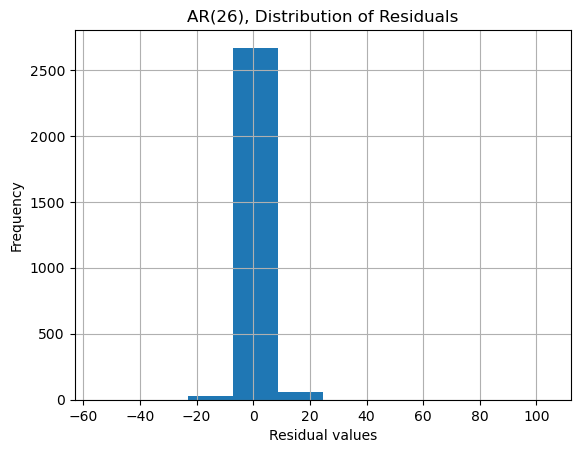

In [13]:
y_train_resid.hist()
plt.xlabel("Residual values")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residuals");

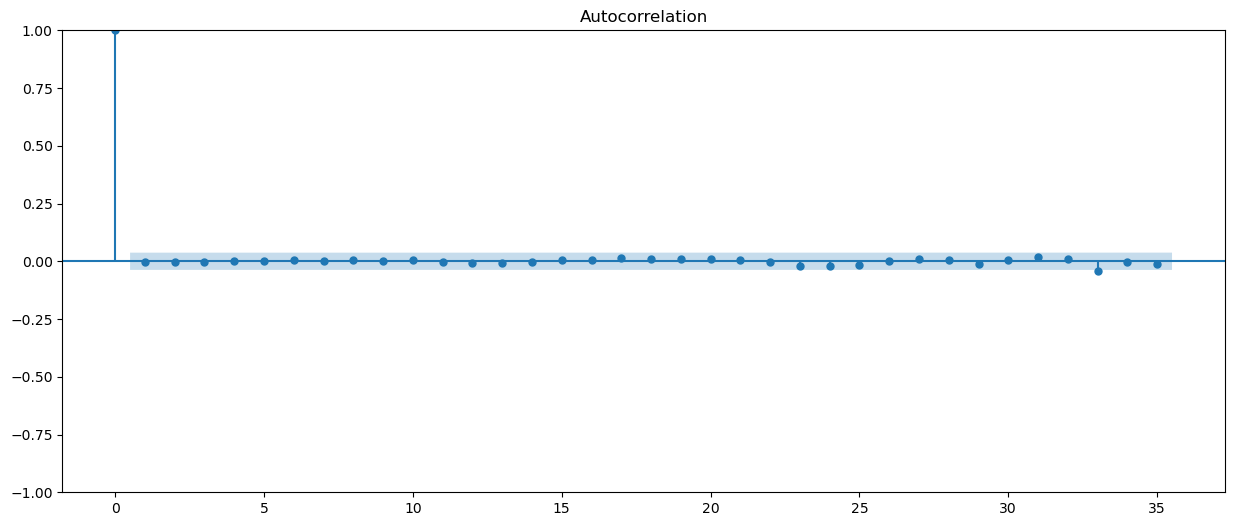

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax);

## Evaluate

### 🧪 Evaluate Model on Test Data

Now that the model has been trained, we assess its performance on unseen data to test how well it generalizes.

**Steps to perform:**

1. **Generate Test Predictions**  
   - Use the fitted model to predict values for the **test period** (`y_test`).  
   - Ensure that the prediction indices align correctly with the test data timestamps.

2. **Calculate Test Mean Absolute Error (MAE)**  
   - Compute the **MAE** between the actual and predicted test values.  
   - This measures the average magnitude of prediction errors on unseen data.  
   - A lower MAE compared to the baseline indicates improved forecasting performance.

3. **Create a Results DataFrame**  
   - Build a new DataFrame called `test_predictions` with two columns:  
     - `"y_test"` → true observed values.  
     - `"y_pred"` → predicted values from the model.  
   - Make sure the index matches that of `y_test` for easy comparison and plotting.

This step helps evaluate the **out-of-sample accuracy** of the model and prepares results for further visualization.


In [15]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae =mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 3.014967498817877


### 🔁 Perform Walk-Forward Validation (WFV)

To simulate real-world forecasting, we use **walk-forward validation**, a method that updates the model as new data becomes available.

**Steps to perform:**

1. **Concept**  
   - Unlike a single train-test split, walk-forward validation retrains (or refits) the model step-by-step as it “walks” through the test set.  
   - At each step:
     - Use all available past data (including newly observed test points) to fit or update the model.  
     - Predict the next time step.

2. **Implementation**  
   - Iterate over each observation in `y_test`.  
   - Fit the model on the current training window (initially `y_train`), predict the next value, and append it to `y_pred_wfv`.  
   - Expand the training window to include the actual observed value before predicting the next point.

3. **Purpose**  
   - This method mimics **real-time forecasting**, where future data isn’t known ahead of time.  
   - It provides a more **robust evaluation** of model performance on sequential data.

4. **Output**  
   - Store all walk-forward predictions in a Series named `y_pred_wfv`, aligned with the index of `y_te_


In [43]:
preds = []
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    preds.append(next_pred.iloc[0])
    history = pd.concat([history, y_test.iloc[[i]]])
y_pred_wfv = pd.Series(preds, index=y_test.index)


In [44]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.4


# Communicate Results

### 📊 Visualize Walk-Forward Validation Predictions

After performing walk-forward validation, we combine the true and predicted values into a single DataFrame for comparison and visualization.

**Steps to perform:**

1. **Create the Results DataFrame**  
   - Combine `y_test` (actual values) and `y_pred_wfv` (predicted values) into a new DataFrame named `df_pred_test`.  
   - Ensure both Series share the same **datetime index** for proper alignment.

2. **Visualize with Plotly Express**  
   - Create an interactive **time series line plot** using Plotly Express (`px.line`).  
   - Plot both `y_test` and `y_pred_wfv` on the same chart to compare actual vs. predicted trends over time.  
   - Label the y-axis as `"P2"` to represent PM2.5 readings.

3. **Purpose**  
   - This visualization clearly shows how well the model tracks real data during the test period.  
   - It helps identify periods where the model performs well or deviates significantly.


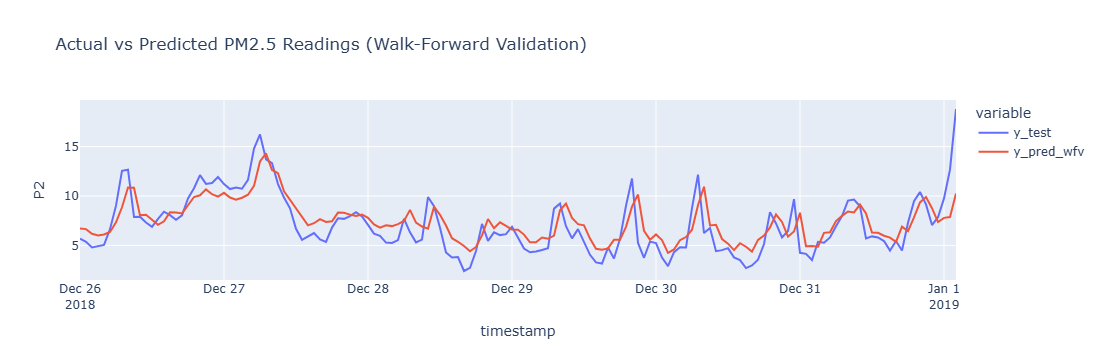

In [48]:
y_test = y_test.squeeze()         
y_pred_wfv = y_pred_wfv.squeeze() 
df_pred_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred_wfv": y_pred_wfv
}, index=y_test.index)
fig = px.line(df_pred_test, labels={"value": "P2", "index": "Timestamp"},
              title="Actual vs Predicted PM2.5 Readings (Walk-Forward Validation)")
fig.show()

## 🏁 Conclusion

In this project, we built and evaluated a **time series forecasting model** to predict PM2.5 air quality readings over time.

**Key Takeaways:**

- 🧹 **Data Preparation:**  
  Cleaned and preprocessed timestamped data, localized it to the *Africa/Nairobi* timezone, and handled outliers and missing values using forward filling.

- ⏱️ **Feature Engineering:**  
  Created lag-based features (e.g., previous-hour readings) to help the model learn temporal dependencies.

- 📊 **Modeling and Evaluation:**  
  Trained an **AutoRegressive (AR)** model using 26 hourly lags, achieving meaningful predictions compared to the baseline.  
  Evaluated model performance with **Mean Absolute Error (MAE)** on both training and test sets.

- 🔁 **Walk-Forward Validation:**  
  Implemented a realistic forecasting approach that simulates predicting future values as new data arrives, confirming the model’s ability to adapt to sequential data.

- 📈 **Visualization:**  
  Used interactive **Plotly** charts to compare actual vs. predicted PM2.5 levels, making it easy to assess forecasting accuracy and patterns over time.

**Overall**, this workflow demonstrates a complete end-to-end **time series forecasting pipeline** — from wrangling and feature engineering to model evaluation and visualization — a valuable skillset for data analytics and predictive modeling projects.
